In [1]:
# Local utilities
from util import *
environment_check()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available
Tensor on GPU: tensor([1., 2., 3.], device='cuda:0')

PyTorch3D is using CUDA


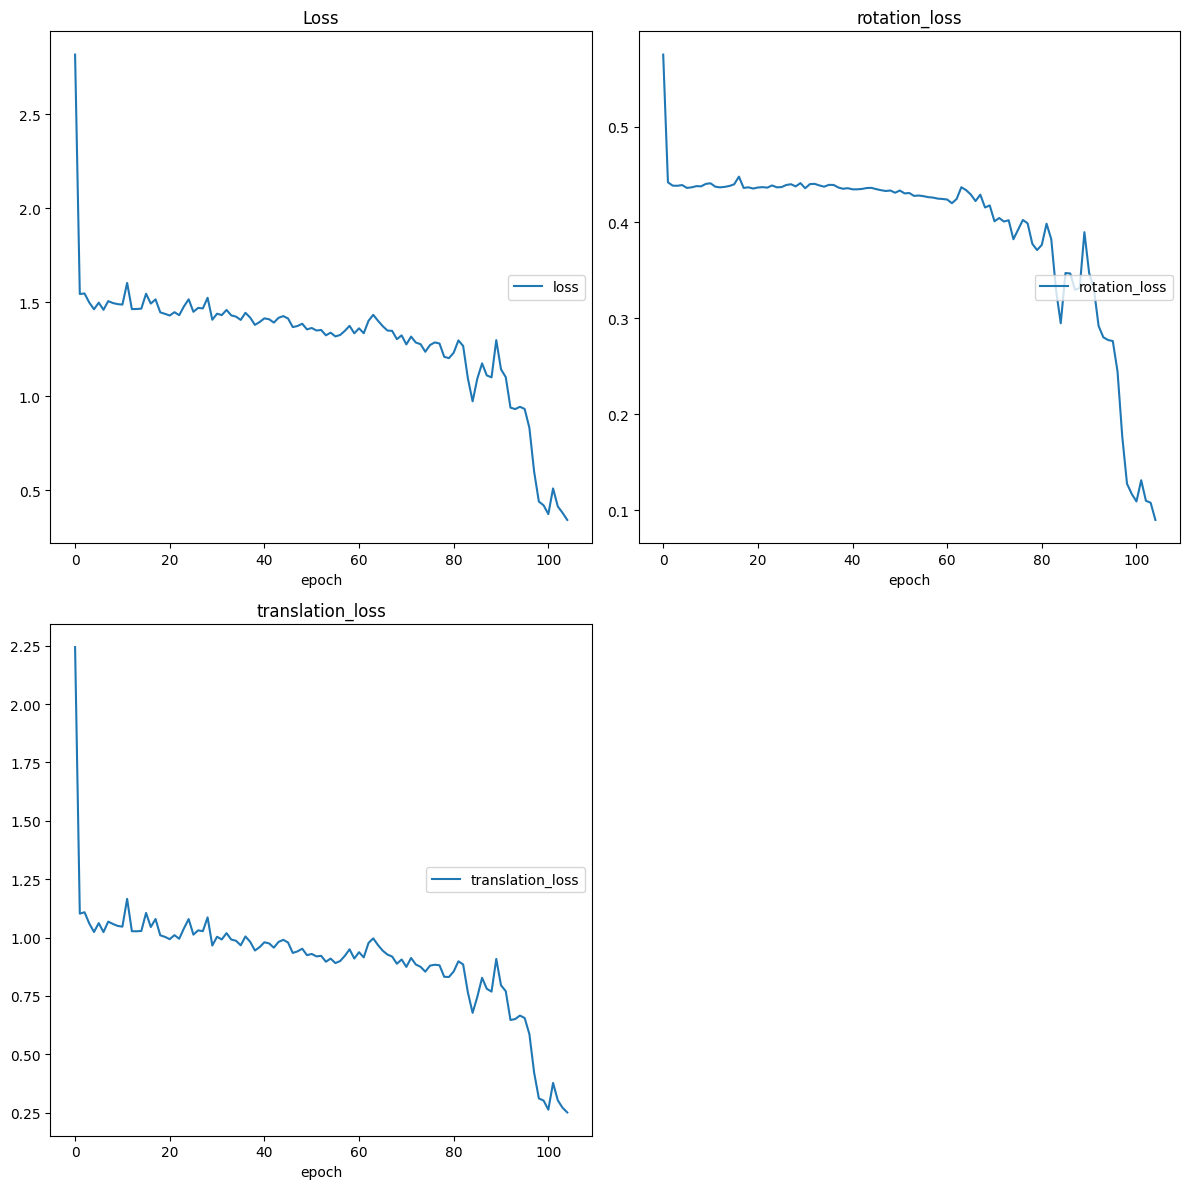

Loss
	loss             	 (min:    0.341, max:    2.819, cur:    0.341)
rotation_loss
	rotation_loss    	 (min:    0.090, max:    0.575, cur:    0.090)
translation_loss
	translation_loss 	 (min:    0.251, max:    2.244, cur:    0.251)


In [ ]:
import torch
import json
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim import Adam
import logging
import torch
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class PoseRefinementDataset(torch.utils.data.Dataset):
    def __init__(self, data_json_filepath):
        with open(data_json_filepath, 'r') as f:
            self.data_json = json.load(f)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        logging.info("Dataset loaded with {} samples".format(len(self.data_json)))

    def __len__(self):
        return len(self.data_json)

    def __getitem__(self, idx):
        entry = self.data_json[idx]
        image = Image.open(entry['silhouette_path']).convert('L').convert('RGB')
        image = self.transform(image)
        rt_matrix = torch.tensor(entry['RT'], dtype=torch.float32)
        if rt_matrix.numel() == 16:
            rt_matrix = rt_matrix.view(4, 4)[:-1]  # Assuming the last row is [0, 0, 0, 1] and can be discarded
        else:
            rt_matrix = rt_matrix.view(3, 4)  # Normal case
        logging.debug(f"Image and RT matrix loaded for index {idx}")
        return image, rt_matrix
    
    def show_sample(self, idx):
        image, rt_matrix = self.__getitem__(idx)
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(image_np)
        plt.title(f"Sample {idx} - RT Matrix: \n{rt_matrix.numpy()}")
        plt.show()    

# Example usage to display a sample from the dataset
dataset = PoseRefinementDataset("./pose_refine_dataset/dataset_info.json")
dataset.show_sample(0)  # Display the first sample
  

 
 


 
    
import torch
import torch.nn as nn
from torchvision.models import vit_b_32, ViT_B_32_Weights
import logging

# It is a working network. When modifing it, please follow the same size input and output, keep the detailed comments and add all logs for GPT to debugs as detail as possible
class ViTImageToRTNetwork(nn.Module):
    """
    It is a working network. When modifying it, please follow the same size input and output,
    keep the detailed comments and add all logs for GPT to debug as detailed as possible.
    """
    def __init__(self):
        super().__init__()
        # Setup logging configuration to display logs during training and evaluation
        logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

        # CNN Layer: A simple convolutional layer with 3 input channels and 3 output channels,
        # using a 3x3 kernel, stride of 1, and padding of 1. This layer is intended to preprocess the input images,
        # potentially enhancing or isolating features before they are passed to the Vision Transformer.
        self.cnn_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        
        # Vision Transformer (ViT) Setup: Using a pretrained ViT model but removing its classification head
        # to adapt it for a regression task. The weights are loaded from a default configuration which has
        # been pretrained on a large dataset.
        self.vit = vit_b_32(weights=ViT_B_32_Weights.DEFAULT)
        self.vit.heads = nn.Identity()  # Removing the classifier head to use ViT as a feature extractor.
        
        # Regression layers to predict rotation and translation matrices:
        # - The rotation regressor outputs a 3x3 matrix, reshaped from a 9-unit vector.
        # - The translation regressor outputs a 3x1 vector.
        self.rotation_regressor = nn.Linear(768, 9)  # Assuming 768-dimensional output from ViT model
        self.translation_regressor = nn.Linear(768, 3)

        # Log the initialization status
        logging.info("ViT model initialized with removed classifier head, regressors added, and preceding CNN layer")

    def forward(self, x):
        # Forward pass of the model:
        # 1. Input x is first passed through the CNN layer.
        x = self.cnn_layer(x)
        
        # 2. The output of the CNN is then passed to the Vision Transformer (ViT).
        features = self.vit(x)
        
        # 3. Extract the 'cls_token' which is used for prediction. In ViT, the first token (cls_token)
        #    often serves as the representation of the sequence for classification tasks. Here, it's used for regression.
        cls_token = features
        
        # 4. Compute the rotation and translation matrices from the cls_token.
        rotation = self.rotation_regressor(cls_token).view(-1, 3, 3)
        translation = self.translation_regressor(cls_token).view(-1, 3, 1)
        
        # 5. Concatenate the rotation and translation matrices to form the RT matrix.
        rt_matrix = torch.cat((rotation, translation), dim=2)
        
        # Log the completion of a forward pass
        logging.debug("Model forward pass completed")
        return rt_matrix

    def load_model_weights(self, weight_path):
        # Load model weights from a specified path
        try:
            self.load_state_dict(torch.load(weight_path))
            logging.info(f"Loaded entire model weights from {weight_path}")
        except Exception as e:
            logging.error(f"Failed to load model weights: {str(e)}")

            
            
from livelossplot import PlotLosses
def train_model(dataset, epochs, batch_size, learning_rate, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = ViTImageToRTNetwork().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    liveloss = PlotLosses()
    # Cosine similarity loss for rotation
    rotation_loss_fn = nn.CosineSimilarity(dim=1, eps=1e-6)
    translation_loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        logs = {}
        model.train()
        total_loss, total_rotation_loss, total_translation_loss = 0, 0, 0
        for images, rt_matrices in loader:
            images = images.to(device)
            rt_matrices = rt_matrices.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            pred_rotation = outputs[:, :, :3]  # 3x3 rotation matrices
            pred_translation = outputs[:, :, 3:]  # translation vectors

            true_rotation = rt_matrices[:, :, :3]
            true_translation = rt_matrices[:, :, 3:]

            # Calculate cosine similarity loss for rotation
            pred_rotation_flat = pred_rotation.reshape(pred_rotation.shape[0], -1)
            true_rotation_flat = true_rotation.reshape(true_rotation.shape[0], -1)
            loss_rotation = 1 - rotation_loss_fn(pred_rotation_flat, true_rotation_flat).mean()  # Take the mean to get a scalar loss

            loss_translation = translation_loss_fn(pred_translation, true_translation)

            # Combine the rotation and translation loss
            loss = loss_rotation + loss_translation
            loss.backward()  # Ensuring that loss is a scalar before backward
            optimizer.step()

            total_loss += loss.item()
            total_rotation_loss += loss_rotation.item()
            total_translation_loss += loss_translation.item()

        logs['loss'] = total_loss / len(loader)
        logs['rotation_loss'] = total_rotation_loss / len(loader)
        logs['translation_loss'] = total_translation_loss / len(loader)
        liveloss.update(logs)
        liveloss.send()

    # Save final model
    torch.save(model.state_dict(), model_save_path.format('final'))



def evaluate_model(dataset, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTImageToRTNetwork().to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.MSELoss()
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, rt_matrices in loader:
            images, rt_matrices = images.to(device), rt_matrices.to(device)
            outputs = model(images)
            loss = criterion(outputs, rt_matrices)
            total_loss += loss.item()
    logging.info(f"Validation Loss: {total_loss / len(loader)}")
# Example usage
dataset = PoseRefinementDataset("./pose_refine_dataset/dataset_info.json")
model_save_path = "./pose_refine_dataset/pose_refine_model_epoch_{}.pth"  # Path where you want to save the model weights
train_model(dataset, epochs=99999, batch_size=8, learning_rate=0.001, model_save_path=model_save_path)

 


In [ ]:
import os

def shutdown_computer():
    print("Shutting down the computer in 1 second...")
    os.system('shutdown /s /t 1')

shutdown_computer()


In [ ]:
dataset_path = "./pose_refine_dataset_e/dataset_info.json"
dataset_e = PoseRefinementDataset(dataset_path)
evaluate_model(dataset_e, batch_size=4)

In [ ]:
import torch
device = torch.device("cpu")
# Assuming the necessary imports are done and device is defined
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

def display_input_image(img_input):
    """
    Display the input image.

    Parameters:
    - img_input: A PyTorch tensor representing the image to be displayed.
    """
    # Convert the PyTorch tensor to a NumPy array and transpose the axes for displaying
    img_np = img_input.cpu().detach().numpy()
    plt.imshow(img_np.transpose(1, 2, 0))
    plt.title("Input Image")
    plt.axis('off')  # Hide axis for cleaner visualization
    plt.show()

def visualize_meshes(mesh_pred):
    """
    Create visualizations for the predicted mesh.

    Parameters:
    - mesh_pred: A PyTorch3D Meshes object representing the predicted mesh.
    """
    # Get vertices and faces from the predicted mesh
    verts, faces = mesh_pred.get_mesh_verts_faces(0)
    original_verts = verts.detach().numpy()
    i, j, k = faces[:, 0].detach().numpy(), faces[:, 1].detach().numpy(), faces[:, 2].detach().numpy()

    # Define the camera view
    camera_view = dict(
        eye=dict(x=0.0, y=0.0, z=2.0),
        up=dict(x=0, y=1, z=0),
        center=dict(x=0, y=0, z=0),
        projection=dict(type='perspective')
    )

    # Create subplot figures for the predicted mesh
    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{'type': 'surface'}]],
        subplot_titles=('Predicted Mesh',)
    )

    # Add predicted mesh to the subplot
    fig.add_trace(
        go.Mesh3d(
            x=original_verts[:, 0], 
            y=original_verts[:, 1], 
            z=original_verts[:, 2], 
            i=i, 
            j=j, 
            k=k, 
            colorscale='Viridis', 
            opacity=0.50
        )
    )

    # Update layout for the subplot
    fig.update_layout(
        autosize=False,
        width=800,  # Adjusted for a single mesh visualization
        height=600,
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="white",
        scene_camera=camera_view
    )
    
    # Show the subplot figure
    fig.show()
    
def visualize_mesh_with_cameras(mesh_gt, camera_poses):
    """
    Visualize the ground truth mesh along with camera frustums to indicate camera positions and orientations.
    """
    camera_view = dict(eye=dict(x=0.0, y=0.0, z=2.0), center=dict(x=0, y=0, z=0),
                       up=dict(x=0, y=1, z=0), projection=dict(type='perspective'))
    scene_layout = dict(xaxis=dict(range=[-3, 3]), yaxis=dict(range=[-3, 3]),
                        zaxis=dict(range=[-3, 3]), camera=camera_view, aspectmode='cube')

    verts_gt, faces_gt = mesh_gt.get_mesh_verts_faces(0)
    mesh_trace_gt = go.Mesh3d(x=verts_gt[:, 0], y=verts_gt[:, 1], z=verts_gt[:, 2],
                              i=faces_gt[:, 0], j=faces_gt[:, 1], k=faces_gt[:, 2],
                              color='lightblue', opacity=0.5, name='GT Mesh')

    fig = go.Figure(data=[mesh_trace_gt])

    for index, RT in enumerate(camera_poses):
        # Decompose the RT matrix to extract the position and the forward vector.
        camera_position = RT[:3, 3].numpy()
        forward_vector = RT[:3, 2].numpy()  # Forward direction (Z-axis)
        end_point = camera_position + forward_vector * 0.3  # Scale the length of the arrow

        # Add the camera position as a dot
        fig.add_trace(go.Scatter3d(
            x=[camera_position[0]],
            y=[camera_position[1]],
            z=[camera_position[2]],
            mode='markers',
            marker=dict(size=5, color='blue'),
            name=f'Camera {index + 1}'
        ))

        # Add an arrow to represent the orientation
        fig.add_trace(go.Scatter3d(
            x=[camera_position[0], end_point[0]],
            y=[camera_position[1], end_point[1]],
            z=[camera_position[2], end_point[2]],
            mode='lines+markers',
            marker=dict(size=2, color='red'),
            line=dict(color='red', width=2),
            showlegend=False
        ))

        # Optionally, add cones to act as arrowheads
        fig.add_trace(go.Cone(
            x=[end_point[0]],
            y=[end_point[1]],
            z=[end_point[2]],
            u=[forward_vector[0]],
            v=[forward_vector[1]],
            w=[forward_vector[2]],
            sizemode='absolute',
            sizeref=0.1,
            anchor='tip',
            showscale=False,
            colorscale=[[0, 'red'], [1, 'red']],
            name=f'Orientation {index + 1}'
        ))

    fig.update_layout(title="Ground Truth Mesh with Camera Frustums", scene=scene_layout, autosize=False,
                      width=800, height=600, margin=dict(l=50, r=50, b=50, t=50))
    fig.show()


In [ ]:
import torch
from pytorch3d.io import load_objs_as_meshes

# Set the device for PyTorch (assumes PyTorch and PyTorch3D are installed and configured)
device = torch.device("cpu")

# Full path to the mesh file
mesh_path = './pose_refine_dataset/meshes/mesh_0.obj'

# Load the mesh file into a PyTorch3D Meshes object
mesh_gt = load_objs_as_meshes([mesh_path], device=device)


# Example usage:
model = ViTImageToRTNetwork()
model.load_model_weights('./pose_refine_dataset/pose_refine_model_epoch_final.pth')

# Assuming dataset is already defined and properly loaded
sample_index = 5  # Get the first sample, for example
image, gt_rt_matrix = dataset_e[sample_index]

# Log the requires_grad status for image and gt_rt_matrix
print(f"image requires_grad: {image.requires_grad}")
print(f"gt_rt_matrix requires_grad: {gt_rt_matrix.requires_grad}")

# Display the input image
display_input_image(image)

# Move image to the device model is on and add batch dimension if necessary
device = next(model.parameters()).device
image = image.unsqueeze(0).to(device)

# Log the requires_grad status after moving to the device
print(f"image after device transfer requires_grad: {image.requires_grad}")

predicted_rt_matrix = model(image)

# Detach the tensor and move it to CPU for further processing without gradients
predicted_rt_matrix = predicted_rt_matrix.detach().cpu()

# Log the requires_grad status for predicted_rt_matrix
print(f"predicted_rt_matrix requires_grad: {predicted_rt_matrix.requires_grad}")

# Visualize the ground truth mesh with predicted camera poses
# Assuming 'mesh_gt' and 'predicted_rt_matrix' are available
visualize_mesh_with_cameras(mesh_gt, [predicted_rt_matrix.squeeze(0), gt_rt_matrix])
